# Project 2: Topic Classification

In this project, you'll work with text data from newsgroup postings on a variety of topics. You'll train classifiers to distinguish between the topics based on the text of the posts. Whereas with digit classification, the input is relatively dense: a 28x28 matrix of pixels, many of which are non-zero, here we'll represent each document with a "bag-of-words" model. As you'll see, this makes the feature representation quite sparse -- only a few words of the total vocabulary are active in any given document. The bag-of-words assumption here is that the label depends only on the words; their order is not important.

The SK-learn documentation on feature extraction will prove useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [16]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
# from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

Load the data, stripping out metadata so that we learn classifiers that only use textual features. By default, newsgroups data is split into train and test sets. We further split the test so we have a dev set. Note that we specify 4 categories to use for this project. If you remove the categories argument from the fetch function, you'll get all 20 categories.

In [17]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories)

num_test = len(newsgroups_test.target)
test_data, test_labels = newsgroups_test.data[num_test//2:], newsgroups_test.target[num_test//2:]
dev_data, dev_labels = newsgroups_test.data[:num_test//2], newsgroups_test.target[:num_test//2]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print ('training label shape:', train_labels.shape)
print ('test label shape:', test_labels.shape)
print ('dev label shape:', dev_labels.shape)
print ('labels names:', newsgroups_train.target_names)

training label shape: (2034,)
test label shape: (677,)
dev label shape: (676,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


(1) For each of the first 5 training examples, print the text of the message along with the label.

[2 pts]

In [18]:
def P1(num_examples=5):
### STUDENT START ###
    for i in range(5):
        print ('Text:\n', train_data[i], '\n')
        print ('Label: ', newsgroups_train.target_names[train_labels[i]], '\n')

### STUDENT END ###
P1(2)

Text:
 Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych 

Label:  comp.graphics 

Text:
 

Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstrating such evil corruption
for centuries. 

Label:  talk.religi

(2) Use CountVectorizer to turn the raw training text into feature vectors. You should use the fit_transform function, which makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").

The vectorizer has a lot of options. To get familiar with some of them, write code to answer these questions:

a. The output of the transform (also of fit_transform) is a sparse matrix: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. What is the size of the vocabulary? What is the average number of non-zero features per example? What fraction of the entries in the matrix are non-zero? Hint: use "nnz" and "shape" attributes.

Answer: Vocabulary size is (2034, 26879). Average number of non-zero features per example is 0.003597827226959026. Fraction of the entries in the matrix that are non-zero is also 0.003597827226959026.

b. What are the 0th and last feature strings (in alphabetical order)? Hint: use the vectorizer's get_feature_names function.

Answer: First (0th) feature: 00, Last feature: zyxel

c. Specify your own vocabulary with 4 words: ["atheism", "graphics", "space", "religion"]. Confirm the training vectors are appropriately shaped. Now what's the average number of non-zero features per example?

Answer: Now the average number of non-zero features per example is 0.06710914454277286.

d. Instead of extracting unigram word features, use "analyzer" and "ngram_range" to extract bigram and trigram character features. What size vocabulary does this yield?

Answer: Now vocabulary size is (2034, 35478).

e. Use the "min_df" argument to prune words that appear in fewer than 10 documents. What size vocabulary does this yield?

Answer: Now vocabulary size is (2034, 3064).

f. Using the standard CountVectorizer, what fraction of the words in the dev data are missing from the vocabulary? Hint: build a vocabulary for both train and dev and look at the size of the difference.

Answer: The fraction of the words in the dev data that missing from the train vocabulary is 0.24787640034470024.

[6 pts]

In [19]:
def P2():
### STUDENT START ###
    vec = CountVectorizer()
    X = vec.fit_transform(train_data)
    
    print ('a')
    print ('Vocabulary size: ', X.shape)
    print ('Average number of non-zero features per example:')
    print (np.sum(np.sum(X!=0, axis=1) / float(X.shape[1])) / float(X.shape[0]))
    print ('Fraction of the entries in the matrix that are non-zero:')
    print (np.sum(X!=0) / float(X.shape[0]*X.shape[1]))
    print ('')
    
    print ('b')
    print ('First feature: ', vec.get_feature_names()[0])
    print ('Last feature: ', vec.get_feature_names()[-1])
    print ('')
    
    print ('c')
    vec = CountVectorizer(vocabulary=['atheism', 'graphics', 'space', 'religion'])
    X_new = vec.fit_transform(train_data)
    print ('Vocabulary size: ', X_new.shape)
    print (np.sum(np.sum(X_new!=0, axis=1) / float(X_new.shape[1])) / float(X_new.shape[0]))
    print ('')
    
    print ('d')
    vec = CountVectorizer(analyzer='char', ngram_range=(2,3))
    X_char = vec.fit_transform(train_data)
    print ('Vocabulary size: ', X_char.shape)
    print ('')
    
    print ('e')
    vec = CountVectorizer(min_df=10)
    X = vec.fit_transform(train_data)
    print ('Vocabulary size: ', X.shape)
    print ('')
    
    print ('f')
    vec_train = CountVectorizer()
    X_train = vec_train.fit_transform(train_data)
    print ('Vocabulary train size: ', X_train.shape)
    vec_dev = CountVectorizer()
    X_dev = vec_dev.fit_transform(dev_data)
    print ('Vocabulary dev size: ', X_dev.shape)
    # logical for features in dev that missing from train
    feat_missing = [f not in vec_train.get_feature_names() for f in vec_dev.get_feature_names()]
    print ('Fraction of dev that missing from train: ', np.sum(feat_missing)/float(X_dev.shape[1]))

### STUDENT END ###
P2()

a
Vocabulary size:  (2034, 26879)
Average number of non-zero features per example:
0.003597827226959026
Fraction of the entries in the matrix that are non-zero:
0.0035978272269590263

b
First feature:  00
Last feature:  zyxel

c
Vocabulary size:  (2034, 4)
0.06710914454277286

d
Vocabulary size:  (2034, 35478)

e
Vocabulary size:  (2034, 3064)

f
Vocabulary train size:  (2034, 26879)
Vocabulary dev size:  (676, 16246)
Fraction of dev that missing from train:  0.24787640034470024


(3) Use the default CountVectorizer options and report the f1 score (use metrics.f1_score) for a k nearest neighbors classifier; find the optimal value for k. Also fit a Multinomial Naive Bayes model and find the optimal value for alpha. Finally, fit a logistic regression model and find the optimal value for the regularization strength C using l2 regularization. A few questions:

a. Why doesn't nearest neighbors work well for this problem?

Answer: Since nearest neighbors method suffers from high dimensionality (the number of examples are significantly lower than the number of features), in such cases "neighborhood" becomes very large.

b. Any ideas why logistic regression doesn't work as well as Naive Bayes?

Answer: Might be because a lot of features are related, and this violates assumption of no multicollinearity (that features are not highly correlated with each other).

c. Logistic regression estimates a weight vector for each class, which you can access with the coef\_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.

Answer: With increase in C (strength of regularization decrease) the sum of squared weights also increase.

[4 pts]

In [20]:
def P3():
### STUDENT START ###

    vec = CountVectorizer()
    X_train = vec.fit_transform(train_data)
    X_dev = vec.transform(dev_data)
    
    print ('K Neighbors Classifier:')
    knn = KNeighborsClassifier()
    parameters = {'n_neighbors':[1, 3, 5, 7, 9, 11]}
    cl = GridSearchCV(knn, parameters, scoring='f1_weighted', cv=5, refit=True)
    cl.fit(X_train, train_labels) 
    print ('Best params: ', cl.best_params_)
    print ('F1 for train data: ', metrics.f1_score(train_labels, cl.predict(X_train), average='weighted'))
    print ('F1 for dev data: ', metrics.f1_score(dev_labels, cl.predict(X_dev), average='weighted'))
    print ('')
    
    print ('Multinomial Naive Bayes:')
    mnb = MultinomialNB()
    parameters = {'alpha': [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
    cl = GridSearchCV(mnb, parameters, scoring='f1_weighted', cv=5, refit=True)
    cl.fit(X_train, train_labels) 
    print ('Best params: ', cl.best_params_)
    print ('F1 for train data: ', metrics.f1_score(train_labels, cl.predict(X_train), average='weighted'))
    print ('F1 for dev data: ', metrics.f1_score(dev_labels, cl.predict(X_dev), average='weighted')) 
    print ('')
    
    
    print ('Logistic Regression:')
    logreg = LogisticRegression(penalty='l2')
    #logreg = LogisticRegression(penalty='l2', solver='lbfgs', multi_class='multinomial')
    parameters = {'C': [0.01, 0.1, 1, 10, 100, 1000]}
    cl = GridSearchCV(logreg, parameters, scoring='f1_weighted', cv=5, refit=True)
    cl.fit(X_train, train_labels) 
    print ('Best params: ', cl.best_params_)
    print ('F1 for train data: ', metrics.f1_score(train_labels, cl.predict(X_train), average='weighted'))
    print ('F1 for dev data: ', metrics.f1_score(dev_labels, cl.predict(X_dev), average='weighted'))
    print ('')
    
    
    print ('Table for c: ')
    for c in [0.01, 0.1, 1, 10, 100, 1000]:
        cl = LogisticRegression(C=c, penalty='l2')
        cl.fit(X_train, train_labels) 
        print ('C: ', c, ' Sum of squared weights: ', np.sum(np.power(cl.coef_,2)))
    

### STUDENT END ###
P3()

K Neighbors Classifier:
Best params:  {'n_neighbors': 7}
F1 for train data:  0.6180112490338939
F1 for dev data:  0.45047910006117586

Multinomial Naive Bayes:
Best params:  {'alpha': 0.01}
F1 for train data:  0.9607769750100741
F1 for dev data:  0.7751663218544357

Logistic Regression:
Best params:  {'C': 1}
F1 for train data:  0.9785840152689672
F1 for dev data:  0.6960862519544118

Table for c: 
C:  0.01  Sum of squared weights:  10.593602784908697
C:  0.1  Sum of squared weights:  102.27273499192248
C:  1  Sum of squared weights:  601.6585786099855
C:  10  Sum of squared weights:  2107.3639235748255
C:  100  Sum of squared weights:  5082.804794653187
C:  1000  Sum of squared weights:  9708.044302872506


ANSWER:

(4) Train a logistic regression model. Find the 5 features with the largest weights for each label -- 20 features in total. Create a table with 20 rows and 4 columns that shows the weight for each of these features for each of the labels. Create the table again with bigram features. Any surprising features in this table?

Answer: The surprising features are "bobby" in "alt.atheism" and "fbi" in "talk.religion.misc". The tables are in outputs below.

[5 pts]

In [21]:
def P4():
### STUDENT START ###
    vec = CountVectorizer()
    X_train = vec.fit_transform(train_data)
    X_dev = vec.transform(dev_data)

    # fit using best C found
    cl = LogisticRegression(C=1, penalty='l2')
    cl.fit(X_train, train_labels) 
    
    print ('Number of non-zero weights: ', sum(sum(cl.coef_ > 0)))
    print ('')

    print ('Top5 features with the largest weights for each category: ')
    top_ind = []
    top_features = []
    for i in range(cl.coef_.shape[0]):
        top_ind.append(list(np.argsort(-cl.coef_[i])[:5]))
        top_features.append([str(vec.get_feature_names()[j]) for j in top_ind[i]])
        print (top_features[i], ' <------- ', newsgroups_train.target_names[i])
    print ('')
    
    print ('A table that shows the weight for each of these features for each of the labels:')
    print (newsgroups_train.target_names)
    for f in np.array(top_ind).flatten():
        print ([cl.coef_[i,f] for i in range(len(newsgroups_train.target_names))])

    
    # Bigrams
    print ('')
    print ('The same for bigrams: ')
    vec = CountVectorizer(ngram_range=(2,2))
    X_train = vec.fit_transform(train_data)
    X_dev = vec.transform(dev_data)
    
    # fit using best C found
    cl = LogisticRegression(C=1, penalty='l2')
    cl.fit(X_train, train_labels) 
        
    print ('Top5 features with the largest weights for each category: ')
    top_ind = []
    top_features = []
    for i in range(cl.coef_.shape[0]):
        top_ind.append(list(np.argsort(-cl.coef_[i])[:5]))
        top_features.append([str(vec.get_feature_names()[j]) for j in top_ind[i]])
        print (top_features[i], ' <------- ', newsgroups_train.target_names[i])
    print ('')
    
   
    print ('A table that shows the weight for each of these features for each of the labels:')
    print (newsgroups_train.target_names)
    for f in np.array(top_ind).flatten():
        print ([cl.coef_[i,f] for i in range(len(newsgroups_train.target_names))])

    

### STUDENT END ###
P4()

Number of non-zero weights:  44810

Top5 features with the largest weights for each category: 
['deletion', 'atheists', 'bobby', 'religion', 'atheism']  <-------  alt.atheism
['graphics', 'image', 'file', '3d', 'computer']  <-------  comp.graphics
['space', 'orbit', 'nasa', 'launch', 'spacecraft']  <-------  sci.space
['christians', 'christian', 'blood', 'fbi', 'order']  <-------  talk.religion.misc

A table that shows the weight for each of these features for each of the labels:
['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']
[1.1247166919198401, -0.39850405049991683, -0.42008859989859704, -0.39620095019611606]
[1.030754235437102, -0.09718624880007307, -0.3193754243746626, -0.8349351515956304]
[0.9900703070140362, -0.22066435135625656, -0.34093122523690955, -0.4631865110617339]
[0.9537874751449528, -0.6168582454268737, -0.7929936653843938, -0.06448460420777202]
[0.939607167054338, -0.41010249220452727, -0.4492374963854428, -0.43463273373761757]
[-0.7584877256721262

(5) Try to improve the logistic regression classifier by passing a custom preprocessor to CountVectorizer. The preprocessing function runs on the raw text, before it is split into words by the tokenizer. Your preprocessor should try to normalize the input in various ways to improve generalization. For example, try lowercasing everything, replacing sequences of numbers with a single token, removing various other non-letter characters, and shortening long words. If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular. With your new preprocessor, how much did you reduce the size of the dictionary?

For reference, I was able to improve dev F1 by 2 points.

[4 pts]

In [29]:
def empty_preprocessor(s):
    return s

def better_preprocessor(s):
### STUDENT START ###
    s = s.lower() # lowercasing
    s = re.sub('[^0-9a-zA-Z]+', ' ', s) # leave only letters and digits
    s = re.sub('\d+', '[number]', s) # replace all numbers with '[number]'
    return s
### STUDENT END ###

def P5():
### STUDENT START ###
    vec = CountVectorizer(preprocessor=better_preprocessor)
    X_train = vec.fit_transform(train_data)
    X_dev = vec.transform(dev_data)
    print ('New vocabulary size: ', X_train.shape[1], ' Old size: 26879', ' Difference: ', 26879 - X_train.shape[1])
    print ('')
    
    cl = LogisticRegression(C=1, penalty='l2')
    cl.fit(X_train, train_labels) 
    
    print ('F1 for train data: ', metrics.f1_score(train_labels, cl.predict(X_train), average='weighted'))
    print ('F1 for dev data: ', metrics.f1_score(dev_labels, cl.predict(X_dev), average='weighted'))
    print ('')
    
### STUDENT END ###

P5()

New vocabulary size:  24005  Old size: 26879  Difference:  2874

F1 for train data:  0.9785840152689672
F1 for dev data:  0.6836263312429368



Answer: We reduced the dictionary by 2874 terms. However, here we didn't observe an improvement, new preprocessor seems to cut some useful info.

(6) The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. That is, logistic regression seeks the set of weights that minimizes errors in the training data AND has a small size. The default regularization, L2, computes this size as the sum of the squared weights (see P3, above). L1 regularization computes this size as the sum of the absolute values of the weights. The result is that whereas L2 regularization makes all the weights relatively small, L1 regularization drives lots of the weights to 0, effectively removing unimportant features.

Train a logistic regression model using a "l1" penalty. Output the number of learned weights that are not equal to zero. How does this compare to the number of non-zero weights you get with "l2"? Now, reduce the size of the vocabulary by keeping only those features that have at least one non-zero weight and retrain a model using "l2".

Answer: Number of non-zero weights with l1-penalty is significantly lower than for l2-penalty.

Make a plot showing accuracy of the re-trained model vs. the vocabulary size you get when pruning unused features by adjusting the C parameter.

Note: The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.01 (the default is .0001).

[4 pts]

C:  0.01
Number of non-zero weights in l1:  18
Pruned vocabulary size:  18
Train accuracy for l1:  0.507866273352999
Train accuracy for l2:  0.5432645034414946 

C:  0.1
Number of non-zero weights in l1:  200
Pruned vocabulary size:  203
Train accuracy for l1:  0.7645034414945919
Train accuracy for l2:  0.8013765978367748 

C:  1
Number of non-zero weights in l1:  1099
Pruned vocabulary size:  1422
Train accuracy for l1:  0.9567354965585054
Train accuracy for l2:  0.9724680432645034 

C:  10
Number of non-zero weights in l1:  2361
Pruned vocabulary size:  2562
Train accuracy for l1:  0.9783677482792527
Train accuracy for l2:  0.9783677482792527 

C:  100
Number of non-zero weights in l1:  8135
Pruned vocabulary size:  7377
Train accuracy for l1:  0.9783677482792527
Train accuracy for l2:  0.9783677482792527 

C:  1000
Number of non-zero weights in l1:  29732
Pruned vocabulary size:  21694
Train accuracy for l1:  0.9783677482792527
Train accuracy for l2:  0.9783677482792527 



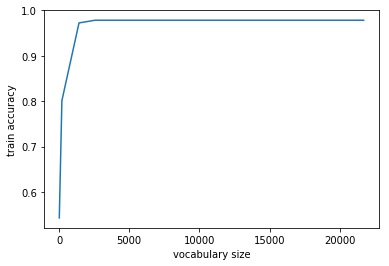

In [33]:
def P6():
    # Keep this random seed here to make comparison easier.
    np.random.seed(0)

    ### STUDENT START ###
    
    acc = []
    voc_size = []
    vec = CountVectorizer(preprocessor=better_preprocessor)
    X_train = vec.fit_transform(train_data)
    X_dev = vec.transform(dev_data)
    for c in [0.01, 0.1, 1, 10, 100, 1000]:
        print ('C: ', c)
        cl = LogisticRegression(C=c, penalty='l1', tol=.01)
        cl.fit(X_train, train_labels) 
        print ('Number of non-zero weights in l1: ', np.sum(cl.coef_ > 0))
        # leave only features that have at least one non-zero weight
        X_train_pruned = X_train[:,[i for i in range(cl.coef_.shape[1]) if any(cl.coef_[:,i])]]
        voc_size.append(X_train_pruned.shape[1])
        print ('Pruned vocabulary size: ', voc_size[-1])
        print ('Train accuracy for l1: ', metrics.accuracy_score(train_labels, cl.predict(X_train)))
        
        cl = LogisticRegression(C=c, penalty='l2')
        cl.fit(X_train_pruned, train_labels)
        acc.append(metrics.accuracy_score(train_labels, cl.predict(X_train_pruned)))
        print ('Train accuracy for l2: ', acc[-1], '\n')
    
    # plotting    
    plt.plot(voc_size, acc)
    plt.xlabel('vocabulary size')
    plt.ylabel('train accuracy')
    plt.show()
    

    ### STUDENT END ###
P6()

(7) Use the TfidfVectorizer -- how is this different from the CountVectorizer? Train a logistic regression model with C=100.

Make predictions on the dev data and show the top 3 documents where the ratio R is largest, where R is:

maximum predicted probability / predicted probability of the correct label

What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

[4 pts]

In [34]:
def P7():
    ### STUDENT START ###

    np.random.seed(0)

    vec = TfidfVectorizer()
    X_train = vec.fit_transform(train_data)
    X_dev = vec.transform(dev_data)

    cl = LogisticRegression(C=100, penalty='l2')
    cl.fit(X_train, train_labels) 
    dev_predict = cl.predict(X_dev)
    print ('F1 for train data: ', metrics.f1_score(train_labels, cl.predict(X_train), average='weighted'))
    print ('F1 for dev data: ', metrics.f1_score(dev_labels, dev_predict, average='weighted'))
    print ('')

    R = []
    for i in range(X_dev.shape[0]):
        prob = cl.predict_proba(X_dev[i])
        R.append(np.max(prob) / prob[:,dev_labels[i]])
        
    
    topR =  sorted(zip(R,range(X_dev.shape[0])), reverse=True)[:3]
    print ('Top 3 R scores:')
    print (topR, '\n')
    
    # list top 3 documents with highest R
    for el in topR:
        print (dev_data[el[1]], '\n\n')
        print ('Actual: ', newsgroups_train.target_names[dev_labels[el[1]]], '  Predicted: ', newsgroups_train.target_names[dev_predict[el[1]]], '\n\n')
        print ('-'*50)


    ### STUDENT END ###
P7()

F1 for train data:  0.9785840152689672
F1 for dev data:  0.7597662427853104

Top 3 R scores:
[(array([929.35742625]), 215), (array([325.00394411]), 665), (array([287.3069226]), 607)] 

I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages
(eliminating many extraneous "that's" and "of's"), and many (minor) errors
have been corrected. This release includes a simplified Joseph Smith Story,
testimonies of the three and eight witnesses, and a "Words-to-Know"
glossary.

As with the previous announcement, readers are reminded that this is a
not-for-profit endeavor. This is a copyrighted work, but people are welcome
to make *verbatim* copies for personal use. People can recuperate the
actual costs of printing (paper, copy center charges), but may not 

ANSWER: CountVectorizer simply counts word frequencies, TfidfVectorizer adjusts for the number of times a word appears in the document and offset by the number of documents in the corpus with this word, it takes into account the fact that some words appear more frequently in general.

(8) EXTRA CREDIT

Try implementing one of your ideas based on your error analysis. Use logistic regression as your underlying model.

- [1 pt] for a reasonable attempt
- [2 pts] for improved performance

In [35]:
def P8():
    ### STUDENT START ###

    np.random.seed(0)
    

    vec = TfidfVectorizer(stop_words='english')
    X_train = vec.fit_transform(train_data)
    X_dev = vec.transform(dev_data)

    cl = LogisticRegression(C=100, penalty='l2')
    cl.fit(X_train, train_labels) 
    dev_predict = cl.predict(X_dev)
    print ('F1 for train data: ', metrics.f1_score(train_labels, cl.predict(X_train), average='weighted'))
    print ('F1 for dev data: ', metrics.f1_score(dev_labels, dev_predict, average='weighted'))
    print ('')

    
    ### STUDENT END ###
P8()

F1 for train data:  0.9785774285434128
F1 for dev data:  0.776890070550045



Answer: One way of improving our model was to remove stopwords, and we see that the dev score has been improved.